In [1]:
import yfinance as yf
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import datetime as dt
from scipy.optimize import minimize
import matplotlib.ticker as mticker

In [33]:
inicio = dt.date(2023, 1, 1)
final = dt.date.today()

In [34]:
lista_temp = list(pd.read_excel('carteirainside.xlsx')['Ativo'])
lista_temp = [ativo + '.SA' for ativo in lista_temp]

precos_temp = yf.download(tickers=lista_temp, start=inicio, end=final)['Adj Close']

[*********************100%%**********************]  43 of 43 completed


In [35]:
precos_temp.dropna(axis=1, inplace=True)

In [36]:
lista_acoes = list(precos_temp.columns)

In [51]:
lista_acoes = ['WEGE3.SA', 'PETR4.SA', 'VALE3.SA', 'ABEV3.SA', 'ITUB4.SA', 'BBDC4.SA', 'BBAS3.SA', 'GGBR4.SA', 'BBSE3.SA', 'ITSA4.SA']

precos = yf.download(tickers=lista_acoes, start=inicio, end=final)['Adj Close']
precos

[                       0%%                      ]

[*********************100%%**********************]  10 of 10 completed


Ticker,ABEV3.SA,BBAS3.SA,BBDC4.SA,BBSE3.SA,GGBR4.SA,ITSA4.SA,ITUB4.SA,PETR4.SA,VALE3.SA,WEGE3.SA
Date,,,,,,,,,,
2023-01-02,13.485133,14.813606,12.868586,29.009094,21.506426,7.078842,22.238422,16.037289,80.482170,37.070698
2023-01-03,13.466127,14.537466,12.229988,28.105545,21.550226,6.901024,21.775311,15.631455,80.338127,36.146366
2023-01-04,13.542153,14.724529,12.264930,28.244555,21.448021,6.960296,21.838879,16.128250,80.482170,36.389614
2023-01-05,13.580167,15.397068,12.797808,28.305372,21.973635,7.061908,22.519918,16.709005,81.832542,36.467449
2023-01-06,13.608676,15.610849,13.155970,29.130726,22.141542,7.180453,22.910387,16.611046,83.128899,37.002590
...,...,...,...,...,...,...,...,...,...,...
2024-06-28,11.410000,26.709999,12.360855,32.930000,18.379999,9.820000,32.392349,38.049999,62.220001,42.127235
2024-07-01,11.450000,26.360001,12.251025,32.820000,18.320000,9.750000,32.240002,38.630001,63.139999,41.970001
2024-07-02,11.460000,26.450001,12.230000,32.830002,18.480000,9.830000,32.660000,38.509998,62.930000,42.029999


In [52]:
retornos = precos.pct_change().apply(lambda x: np.log(1+x)).dropna() # Retorno logarítmico
media_retornos = retornos.mean()
matriz_cov = retornos.cov()

print(media_retornos, matriz_cov)

Ticker
ABEV3.SA   -0.000436
BBAS3.SA    0.001586
BBDC4.SA   -0.000116
BBSE3.SA    0.000357
GGBR4.SA   -0.000439
ITSA4.SA    0.000921
ITUB4.SA    0.001045
PETR4.SA    0.002252
VALE3.SA   -0.000617
WEGE3.SA    0.000326
dtype: float64 Ticker    ABEV3.SA  BBAS3.SA  BBDC4.SA  BBSE3.SA  GGBR4.SA  ITSA4.SA  \
Ticker                                                                 
ABEV3.SA  0.000156  0.000056  0.000086  0.000033  0.000035  0.000072   
BBAS3.SA  0.000056  0.000190  0.000108  0.000047  0.000049  0.000103   
BBDC4.SA  0.000086  0.000108  0.000356  0.000042  0.000083  0.000153   
BBSE3.SA  0.000033  0.000047  0.000042  0.000137  0.000036  0.000051   
GGBR4.SA  0.000035  0.000049  0.000083  0.000036  0.000309  0.000074   
ITSA4.SA  0.000072  0.000103  0.000153  0.000051  0.000074  0.000158   
ITUB4.SA  0.000069  0.000111  0.000172  0.000050  0.000072  0.000153   
PETR4.SA  0.000021  0.000089  0.000046  0.000025  0.000056  0.000053   
VALE3.SA  0.000025  0.000028  0.000053  0.000013

In [53]:
numero_carteiras = 100000
tabela_retornos_esperados = np.zeros(numero_carteiras) # Não é uma tabela, é uma série (vetor)
tabela_volatilidades_esperadas = np.zeros(numero_carteiras) # Não é uma tabela, é uma série (vetor)
tabela_sharpes = np.zeros(numero_carteiras) # Não é uma tabela, é uma série (vetor)
tabela_pesos = np.zeros((numero_carteiras, len(lista_acoes))) # Aqui é tabela mesmo hehehe

for k in range(numero_carteiras):
    pesos = np.random.random(len(lista_acoes))
    pesos = pesos/np.sum(pesos) # Normalização para 100%
    tabela_pesos[k, :] = pesos

    tabela_retornos_esperados[k] = np.sum(media_retornos * pesos * 252)

    tabela_volatilidades_esperadas[k] = np.sqrt(np.dot(pesos.T, np.dot(matriz_cov * 252, pesos)))
    
    tabela_sharpes[k] = tabela_retornos_esperados[k] / tabela_volatilidades_esperadas[k]

In [54]:
sharpe_maximo = tabela_sharpes.argmax()
sharpe_maximo

44281

In [55]:
tabela_pesos[sharpe_maximo]

array([0.03009387, 0.23220234, 0.00063913, 0.07214621, 0.04352685,
       0.00160295, 0.25995847, 0.34957319, 0.00944328, 0.00081372])

In [56]:
# Retoma o retorno para aritmético exponencial

tabela_retornos_esperados_arit = np.exp(tabela_retornos_esperados) - 1

tabela_retornos_esperados_arit

array([0.14787857, 0.03938863, 0.15871649, ..., 0.04200673, 0.11502902,
       0.05590916])

In [57]:
eixo_y_fronteira_eficiente = np.linspace(tabela_retornos_esperados_arit.min(), tabela_retornos_esperados_arit.max(), 50)

def pegando_retorno(peso_teste):
    peso_teste = np.array(peso_teste)
    retorno = np.sum(media_retornos * peso_teste * 252)
    retorno = np.exp(retorno) - 1

    return retorno

def checando_soma_pesos(peso_teste):
    return np.sum(peso_teste) - 1

def pegando_vol(peso_teste):
    peso_teste = np.array(peso_teste)
    vol = np.sqrt(np.dot(peso_teste.T, np.dot(matriz_cov * 252, peso_teste)))
    return vol

peso_inicial = [1/len(lista_acoes)] * len(lista_acoes) # Isso vira uma carteira com pesos iguais
limites = tuple([(0,1) for ativo in lista_acoes]) # Ativo tem peso 0 ou 1

eixo_x_fronteira_eficiente = []

for retorno_possivel in eixo_y_fronteira_eficiente:
    restricoes = ({'type': 'eq', 'fun': checando_soma_pesos},
                   {'type': 'eq', 'fun': lambda w: pegando_retorno(w) - retorno_possivel})
    
    result = minimize(pegando_vol, peso_inicial, bounds = limites, method='SLSQP', constraints = restricoes)
    eixo_x_fronteira_eficiente.append(result['fun'])

In [58]:
result

 message: Optimization terminated successfully
 success: True
  status: 0
     fun: 0.16267559591063402
       x: [ 6.994e-18  3.415e-01  0.000e+00  1.137e-01  2.090e-17
            2.074e-17  1.218e-01  2.956e-01  4.943e-18  1.274e-01]
     nit: 12
     jac: [ 6.692e-02  1.765e-01  1.247e-01  7.441e-02  8.085e-02
            1.238e-01  1.313e-01  2.329e-01  6.152e-02  7.146e-02]
    nfev: 132
    njev: 12

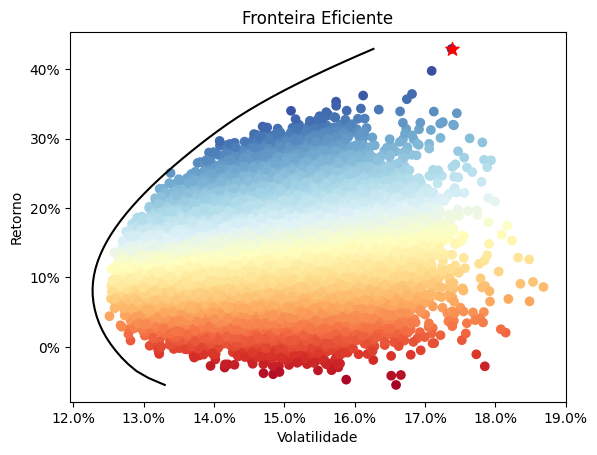

In [59]:
fig, ax = plt.subplots()

ax.scatter(tabela_volatilidades_esperadas, tabela_retornos_esperados_arit, c=tabela_sharpes, cmap='RdYlBu')

ax.set_xlabel('Volatilidade')
ax.set_ylabel('Retorno')
ax.set_title('Fronteira Eficiente')

ax.scatter(tabela_volatilidades_esperadas[sharpe_maximo], tabela_retornos_esperados_arit[sharpe_maximo], c='red', marker='*', s=100)

ax.plot(eixo_x_fronteira_eficiente, eixo_y_fronteira_eficiente, color='black')
ax.yaxis.set_major_formatter(mticker.PercentFormatter(1.0))
ax.xaxis.set_major_formatter(mticker.PercentFormatter(1.0))

plt.show()

In [49]:
df = pd.DataFrame({'Ativo': lista_acoes, 'Peso': tabela_pesos[sharpe_maximo]})
df.Peso = df.Peso * 100
df.Peso = df.Peso.round(2)
df.Peso = df.Peso.astype(str) + '%'
df['Ativo'] = df['Ativo'].str.replace('.SA', '')
df.set_index('Ativo', inplace=True)
df_organizado = df.Peso.sort_values(ascending=False)
df_organizado


Ativo
BBAS3     5.17%
CMIG4     5.09%
LEVE3     4.76%
JBSS3     4.72%
BRFS3     4.64%
TGMA3     4.48%
MRVE3      4.4%
ITSA4     4.36%
SMTO3     4.16%
OPCT3     4.09%
SUZB3     4.03%
BBSE3     3.72%
FLRY3     3.47%
CSMG3     3.45%
SAPR11    3.36%
AGRO3     3.17%
BRIT3     3.16%
BBDC4      2.8%
SBSP3     2.49%
CMIN3     2.44%
GMAT3     2.38%
TOTS3     2.21%
BRSR6      2.1%
ARZZ3     2.08%
MLAS3     1.98%
CSAN3     1.17%
GOAU4     1.17%
LAVV3      1.1%
EVEN3     1.05%
AURE3     1.03%
VALE3     0.98%
BMOB3     0.97%
ALUP11    0.84%
NGRD3     0.69%
INTB3      0.6%
PETR4      0.5%
ELET6     0.41%
ESPA3     0.29%
CVCB3     0.19%
BEEF3     0.12%
HAPV3     0.09%
ALPA4     0.08%
Name: Peso, dtype: object

In [50]:
# save df_organizado in xlsx file
df_organizado.to_excel('markovitzv2.xlsx')